In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Constants 
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
OUT_PATH=DATA_PATH+'/results/fig_simu.rv1'

# GS 
GS_LIST = ['%s_ngene%d'%(prefix, size) for prefix in ['all', 'highmean', 'highvar', 'highbvar']
           for size in [100, 500, 1000, 2000]]
temp_dic = {'all': 'random genes', 'highmean': 'random high mean-expr genes',
            'highvar': 'random high variance genes', 'highbvar': 'random overdispersed genes'}
DIC_GS_NAME = {x:x.split('_')[1].replace('ngene','')+' '+temp_dic[x.split('_')[0]] 
               for x in GS_LIST}

# DATA_LIST
DATA_LIST = ['tms_facs.ncell_10k']

# Results 
DIC_RES_PATH = {
    'scdrs' : DATA_PATH+'/simulation_data/score_file.rv1/@d.@g.weighted',
    'scdrs.bg' : DATA_PATH+'/simulation_data/score_file.rv1/@d.@g',
    'scdrs.ap' : DATA_PATH+'/simulation_data/score_file.rv1/@d.@g.weighted.adj_prop',
    'scdrs.ap.adj_gs': DATA_PATH+'/simulation_data/score_file.rv1/@d.adj_@g.weighted.adj_prop',
    'seurat' : DATA_PATH+'/simulation_data/score_file.rv1/result_scanpy/@d.@g',
    'vision' : DATA_PATH+'/simulation_data/score_file.rv1/result_vision/@d.@g',
    'vam' : DATA_PATH+'/simulation_data/score_file.rv1/result_vam/@d.@g.tsv',
    # Gene sets using ctp-adjusted mean&var
#     'scdrs.adj_gs': DATA_PATH+'/simulation_data/score_file.rv1/@d.adj_@g.weighted',
#     'scdrs.bg.adj_gs': DATA_PATH+'/simulation_data/score_file.rv1/@d.adj_@g',
}

METHOD_LIST = list(DIC_RES_PATH.keys())
DIC_METHOD_NAME = {
    'scdrs':'scDRS', 
    'scdrs.bg': 'scDRS-bin-gs', 
    'scdrs.ap.adj_gs':'scDRS-adj-ctp',
    'seurat': 'Seurat',
    'vision': 'Vision',
    'vam':'VAM', 
#     'scdrs.adj_gs':'scDRS-wgs', 
#     'scdrs.bg.adj_gs': 'scDRS-bin-wgs', 
#     'scdrs.ap':'scDRS-adj',
                  }
DIC_METHOD_COLOR = {
    'scdrs':'C0', 
    'seurat': 'C1',
    'vision':'C2',
    'vam':'C3', 
    'scdrs.bg': 'C4', 
    'scdrs.ap.adj_gs':'C6',
#     'scdrs.adj_gs':'C7',
#     'scdrs.bg.adj_gs': 'C8',
#     'scdrs.ap':'C9',
                   }

for method in METHOD_LIST:
    if method not in DIC_METHOD_NAME.keys():
        DIC_METHOD_NAME[method] = method
    if method not in DIC_METHOD_COLOR.keys():
        DIC_METHOD_COLOR[method] = 'C%d'%len(DIC_METHOD_COLOR)

In [3]:
# Read results 
import itertools

q_list = 10**np.linspace(-3,0,30)
dic_res = {}

for gs,dname,method in itertools.product(GS_LIST, DATA_LIST, METHOD_LIST):

    # Skip for random gene sets with adj_gs
    if gs.startswith('all') & method.endswith('adj_gs'):
        continue
    print('|{:^25s}|{:^25s}|{:^20s}|'.format(gs,dname,method))
    
    if method.endswith('adj_gs'):
        df_gs = pd.read_csv(DATA_PATH+'/simulation_data/gs_file.rv1/adj_%s.gs'%gs, sep='\t', index_col=0) 
    else:
        df_gs = pd.read_csv(DATA_PATH+'/simulation_data/gs_file.rv1/%s.gs'%gs, sep='\t', index_col=0) 
    df_res = pd.DataFrame(index=df_gs.index, columns=q_list, data=-1)

    # Load scDRS results 
    if method.startswith('scdrs'):
        for trait in df_gs.index:
            score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t')
                df_res.loc[trait, q_list] = np.quantile(temp_df['pval'], q_list)
            else:
                print('# %s: file missing: '%method, score_file)
        dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
            
    # Load vam results 
    if method=='vam':
        score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) 
        if os.path.exists(score_file):
            temp_df = pd.read_csv(score_file, sep='\t')
            temp_df.columns = [x.replace('.','_') for x in temp_df.columns]
            drop_list = temp_df.columns[temp_df.mean(axis=0)>0.99]
            for trait in df_gs.index:
                if trait in drop_list: 
                    print('# vam: %s dropped'%trait)
                    continue
                df_res.loc[trait, q_list] = np.quantile(temp_df[trait], q_list)
            df_res = df_res.loc[(df_res==-1).sum(axis=1)==0]
            dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
        else:
            print('# file missing: ', score_file)
            
    # Load vision results        
    if method=='vision':
        for trait in df_gs.index:
            score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t')
                df_res.loc[trait, q_list] = np.quantile(temp_df['norm_pval'], q_list)
            else:
                print('# vision: file missing: ', score_file)
        dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
        
    # Load seurat results
    if method=='seurat':
        for trait in df_gs.index:
            score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.score.gz'%trait
            if os.path.exists(score_file):
                temp_df = pd.read_csv(score_file, sep='\t')
                df_res.loc[trait, q_list] = np.quantile(temp_df['pval'], q_list)
            else:
                print('# seurat: file missing: ', score_file)
        dic_res['%s:%s:%s'%(dname,gs,method)] = df_res.copy()
        
        
# Aggregate all results for adj_gs
for dname in DATA_LIST:
    for gs in ['all_ngene%d'%(size) for size in [100, 500, 1000, 2000]]:
        for method in ['scdrs.adj_gs', 'scdrs.bg.adj_gs', 'scdrs.ap.adj_gs']:
            dic_res['%s:%s:%s'%(dname,gs,method)] = dic_res['%s:%s:%s'%(dname,gs,method.replace('.adj_gs',''))]

|      all_ngene100       |   tms_facs.ncell_10k    |       scdrs        |
|      all_ngene100       |   tms_facs.ncell_10k    |      scdrs.bg      |
|      all_ngene100       |   tms_facs.ncell_10k    |      scdrs.ap      |
|      all_ngene100       |   tms_facs.ncell_10k    |       seurat       |
|      all_ngene100       |   tms_facs.ncell_10k    |       vision       |
|      all_ngene100       |   tms_facs.ncell_10k    |        vam         |
|      all_ngene500       |   tms_facs.ncell_10k    |       scdrs        |
|      all_ngene500       |   tms_facs.ncell_10k    |      scdrs.bg      |
|      all_ngene500       |   tms_facs.ncell_10k    |      scdrs.ap      |
|      all_ngene500       |   tms_facs.ncell_10k    |       seurat       |
|      all_ngene500       |   tms_facs.ncell_10k    |       vision       |
|      all_ngene500       |   tms_facs.ncell_10k    |        vam         |
|      all_ngene1000      |   tms_facs.ncell_10k    |       scdrs        |
|      all_ngene1000     

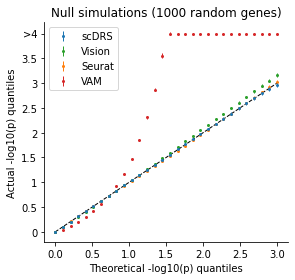

In [5]:
# Q-Q plot main
dname = 'tms_facs.ncell_10k'
plot_method_list = ['scdrs', 'vision', 'seurat', 'vam']

plot_name = 'tms_facs.ncell_10k:all_ngene1000'
dname,gs=plot_name.split(':')
df_plot_mean = pd.DataFrame(index=q_list, columns=plot_method_list, data=-1)
df_plot_se = pd.DataFrame(index=q_list, columns=plot_method_list, data=-1)

for method in plot_method_list:
    res = '%s:%s'%(plot_name,method)
    temp_df = dic_res[res][q_list].loc[(dic_res[res][q_list]==-1).sum(axis=1)==0]

    df_plot_mean.loc[q_list, method] = temp_df.mean(axis=0)
    df_plot_se.loc[q_list, method] = temp_df.std(axis=0)/np.sqrt(temp_df.shape[0])

df_plot_mean = df_plot_mean.clip(lower=1e-4)
df_plot_se = df_plot_se.clip(lower=1e-10)    

# Compute distance and p-value
df_plot_dist = np.absolute(np.log10(df_plot_mean.T)-np.log10(df_plot_mean.index)).T
df_plot_dist.drop(1, axis=0, inplace=True)
df_plot_dist = df_plot_dist.max(axis=0)

temp_df = np.absolute(df_plot_mean.T-df_plot_mean.index).T / df_plot_se
df_plot_p = pd.DataFrame(index=df_plot_mean.index, columns=df_plot_mean.columns, 
                         data=(1-sp.stats.norm.cdf(temp_df))*2)
df_plot_p.drop(1, axis=0, inplace=True)
df_plot_p = df_plot_p.median(axis=0)

# Plot 
plt.figure(figsize=[4.2,4])
ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
df_plot_logerr = np.log10(df_plot_mean+1.96*df_plot_se) - np.log10(df_plot_mean)
for i_method,method in enumerate(plot_method_list):
    plt.errorbar(-np.log10(df_plot_mean.index), -np.log10(df_plot_mean[method]), 
                 yerr = df_plot_logerr[method], label=DIC_METHOD_NAME[method],
                 fmt='.', markersize=4, elinewidth=1, color=DIC_METHOD_COLOR[method], zorder=8-i_method)

plt.plot([0, 3], [0, 3], linestyle='--', linewidth=1, color='k', zorder=0)
plt.xlabel('Theoretical -log10(p) quantiles')
plt.ylabel('Actual -log10(p) quantiles')
plt.yticks([0,0.5,1,1.5,2,2.5,3,3.5,4],[0,0.5,1,1.5,2,2.5,3,3.5,'>4'])
# plt.grid(linestyle='--', linewidth=0.5)
if 'all' in gs:
    plt.title('Null simulations (%s)'%DIC_GS_NAME[gs])
else:
    plt.title('Null simulations\n(%s)'%DIC_GS_NAME[gs])
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PATH+'/fig2a.%s.%s.svg'%(dname,gs))
plt.show()

# Store data for the main figure 'tms_facs.ncell_10k:all_ngene1000'
SUPP_TAB_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/supp_table.rv1'
df_plot_mean.columns = ['%s.mean'%x for x in df_plot_mean]
df_plot_se.columns = ['%s.se'%x for x in df_plot_se]
df_out = df_plot_mean.join(df_plot_se)
df_out.index.name='quantile'
df_out = df_out[['%s.%s'%(x,y) for x in plot_method_list for y in ['mean', 'se']]]
df_out.to_csv(SUPP_TAB_PATH+'/supp_tab_fig2a.tsv', sep='\t')

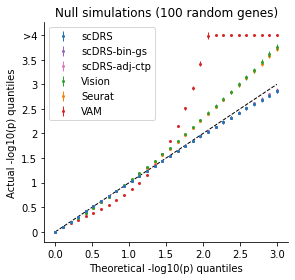

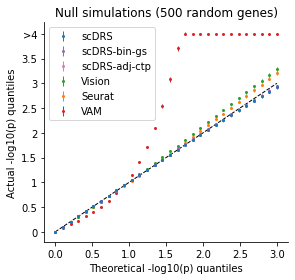

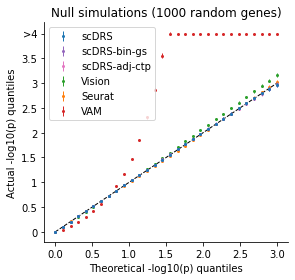

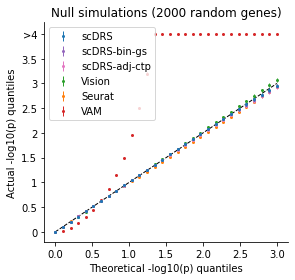

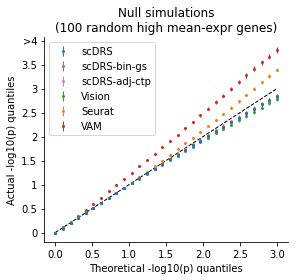

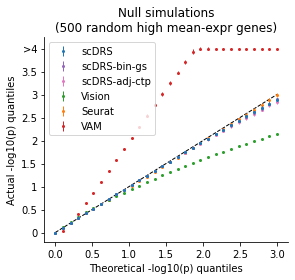

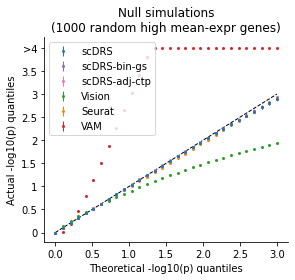

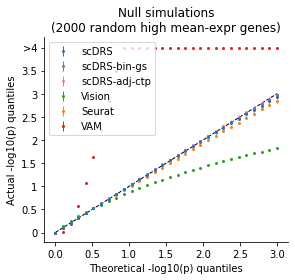

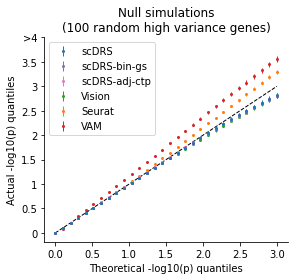

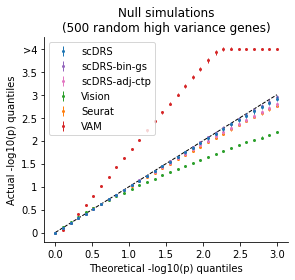

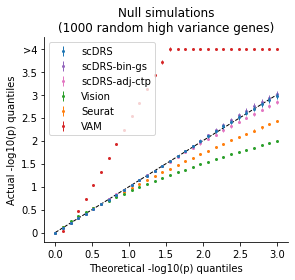

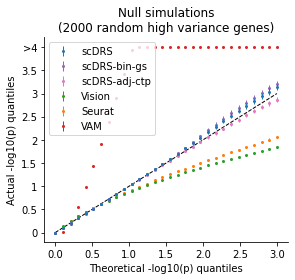

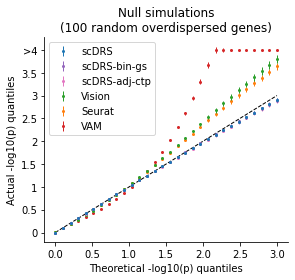

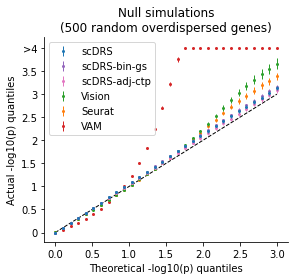

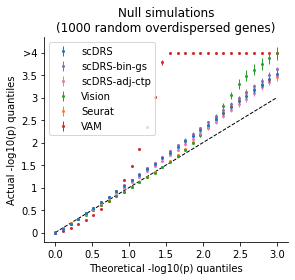

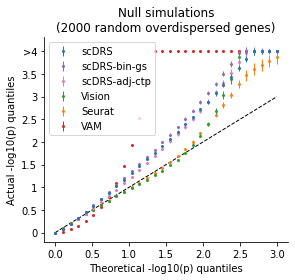

In [6]:
# Q-Q plot supp
dname = 'tms_facs.ncell_10k'
plot_list = ['%s:%s'%(dname, x) for x in GS_LIST]
plot_method_list = ['scdrs', 'scdrs.bg', 'scdrs.ap.adj_gs', 'vision', 'seurat', 'vam']
# plot_method_list = ['scdrs.adj_gs', 'scdrs.bg.adj_gs', 'scdrs.ap.adj_gs']

for plot_name in plot_list:
    dname,gs=plot_name.split(':')
    df_plot_mean = pd.DataFrame(index=q_list, columns=plot_method_list, data=-1)
    df_plot_se = pd.DataFrame(index=q_list, columns=plot_method_list, data=-1)
    
    for method in plot_method_list:
        res = '%s:%s'%(plot_name,method)
        temp_df = dic_res[res][q_list].loc[(dic_res[res][q_list]==-1).sum(axis=1)==0]
        
        df_plot_mean.loc[q_list, method] = temp_df.mean(axis=0)
        df_plot_se.loc[q_list, method] = temp_df.std(axis=0)/np.sqrt(temp_df.shape[0])
        
    df_plot_mean = df_plot_mean.clip(lower=1e-4)
    df_plot_se = df_plot_se.clip(lower=1e-10)    
    
    # Compute distance and p-value
    df_plot_dist = np.absolute(np.log10(df_plot_mean.T)-np.log10(df_plot_mean.index)).T
    df_plot_dist.drop(1, axis=0, inplace=True)
    df_plot_dist = df_plot_dist.max(axis=0)
    
    temp_df = np.absolute(df_plot_mean.T-df_plot_mean.index).T / df_plot_se
    df_plot_p = pd.DataFrame(index=df_plot_mean.index, columns=df_plot_mean.columns, 
                             data=(1-sp.stats.norm.cdf(temp_df))*2)
    df_plot_p.drop(1, axis=0, inplace=True)
    df_plot_p = df_plot_p.median(axis=0)
    
    # Plot 
    plt.figure(figsize=[4.2,4])
    ax = plt.subplot(1,1,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    df_plot_logerr = np.log10(df_plot_mean+1.96*df_plot_se) - np.log10(df_plot_mean)
    for i_method,method in enumerate(plot_method_list):
        plt.errorbar(-np.log10(df_plot_mean.index), -np.log10(df_plot_mean[method]), 
                     yerr = df_plot_logerr[method], label=DIC_METHOD_NAME[method],
                     fmt='.', markersize=4, elinewidth=1, color=DIC_METHOD_COLOR[method], zorder=8-i_method)

    plt.plot([0, 3], [0, 3], linestyle='--', linewidth=1, color='k', zorder=0)
    plt.xlabel('Theoretical -log10(p) quantiles')
    plt.ylabel('Actual -log10(p) quantiles')
    plt.yticks([0,0.5,1,1.5,2,2.5,3,3.5,4],[0,0.5,1,1.5,2,2.5,3,3.5,'>4'])
#     plt.grid(linestyle='--', linewidth=0.5)
    if 'all' in gs:
        plt.title('Null simulations (%s)'%DIC_GS_NAME[gs])
    else:
        plt.title('Null simulations\n(%s)'%DIC_GS_NAME[gs])
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_PATH+'/%s.%s.svg'%(dname,gs))
    plt.show()

### Cell type-disease association 

In [18]:
# Check missing full_score files 
import itertools
for gs,dname,method in itertools.product(
    GS_LIST, DATA_LIST, ['scdrs', 'scdrs.bg', 'scdrs.ap', 'scdrs.ap.adj_gs']
):
    if gs.startswith('all') & method.endswith('adj_gs'):
        continue
    print('|{:^25s}|{:^25s}|{:^20s}|'.format(gs,dname,method))
    if method.endswith('adj_gs'):
        df_gs = pd.read_csv(DATA_PATH+'/simulation_data/gs_file.rv1/adj_%s.gs'%gs, sep='\t', index_col=0)
    else:
        df_gs = pd.read_csv(DATA_PATH+'/simulation_data/gs_file.rv1/%s.gs'%gs, sep='\t', index_col=0)
    
    for trait in df_gs.index:
        score_file = DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.full_score.gz'%trait
        
        if os.path.exists(score_file) is False:
            print('# Missing: ', score_file)
            break

|      all_ngene100       |   tms_facs.ncell_10k    |       scdrs        |
|      all_ngene100       |   tms_facs.ncell_10k    |      scdrs.bg      |
|      all_ngene100       |   tms_facs.ncell_10k    |      scdrs.ap      |
|      all_ngene500       |   tms_facs.ncell_10k    |       scdrs        |
|      all_ngene500       |   tms_facs.ncell_10k    |      scdrs.bg      |
|      all_ngene500       |   tms_facs.ncell_10k    |      scdrs.ap      |
|      all_ngene1000      |   tms_facs.ncell_10k    |       scdrs        |
|      all_ngene1000      |   tms_facs.ncell_10k    |      scdrs.bg      |
|      all_ngene1000      |   tms_facs.ncell_10k    |      scdrs.ap      |
|      all_ngene2000      |   tms_facs.ncell_10k    |       scdrs        |
|      all_ngene2000      |   tms_facs.ncell_10k    |      scdrs.bg      |
|      all_ngene2000      |   tms_facs.ncell_10k    |      scdrs.ap      |
|    highmean_ngene100    |   tms_facs.ncell_10k    |       scdrs        |
|    highmean_ngene100   

In [22]:
# Testing for all methods 
adata = sc.read_h5ad(DATA_PATH+'/simulation_data/single_cell_data/tms_facs.ncell_10k.h5ad')
celltype_list = sorted(set(adata.obs['cell_ontology_class']))

# Read full score
dic_stats = {}
for method in ['scdrs', 'scdrs.bg', 'scdrs.ap', 'scdrs.ap.adj_gs']:
# for method in ['scdrs.ap', 'scdrs.ap.adj_gs']:
    for gs in GS_LIST:
#     for gs in ['all_ngene1000', 'highmean_ngene100']:

        if gs.startswith('all') & method.endswith('adj_gs'):
            continue
        if (gs.startswith('all') is False) & (method=='scdrs.ap'):
            continue
            
        if method.endswith('adj_gs'):
            df_gs = pd.read_csv(DATA_PATH+'/simulation_data/gs_file.rv1/adj_%s.gs'%gs, sep='\t', index_col=0)
        else:
            df_gs = pd.read_csv(DATA_PATH+'/simulation_data/gs_file.rv1/%s.gs'%gs, sep='\t', index_col=0)
        trait_list = list(df_gs.index)
#         trait_list = trait_list[:5]
        dic_full_score = {}
        
        # Read full_score.gz files for a given method-gs config
        for trait in trait_list:
            score_file=DIC_RES_PATH[method].replace('@d',dname).replace('@g',gs) + '/%s.full_score.gz'%trait
            if os.path.exists(score_file):
                dic_full_score[trait] = pd.read_csv(score_file, sep='\t', index_col=0)
            else:
                print('# file missing: ', score_file)
                
        # Compute cell type-disease associations
        df_stats = pd.DataFrame(index=celltype_list, columns=trait_list, dtype=float)
        for trait in trait_list:
            for ct in celltype_list:
                cell_list = adata.obs_names[adata.obs['cell_ontology_class']==ct]
                temp_df = dic_full_score[trait].loc[cell_list].copy()
                score_q95 = np.quantile(temp_df['norm_score'], 0.95)
                temp_df = temp_df[[x for x in temp_df.columns if x.startswith('ctrl_norm_score')]]
                v_ctrl_score_q95 = np.quantile(temp_df, 0.95, axis=0)
                df_stats.loc[ct,trait] = ((v_ctrl_score_q95>=score_q95).sum()+1) / (v_ctrl_score_q95.shape[0]+1)
        dic_stats['%s:%s'%(method,gs)] = df_stats.copy()
        
        # Print results
        df_stats_fdr = df_stats.copy()
        for col in df_stats_fdr:
            df_stats_fdr[col] = multipletests(df_stats[col], method='fdr_bh')[1]
        print('|{:^20s}|{:^20s}|{:^30s}|{:^30s}|'.format(
            method, gs, 'n_celltype=%d'%df_stats_fdr.shape[0], 'n_rep=%d'%df_stats_fdr.shape[1]
        ))
        for alpha in [0.05, 0.1, 0.2]:
            v_fd = (df_stats_fdr<alpha).sum(axis=0)
            v_d = v_fd.clip(lower=1)
            v_fdp = v_fd / v_d
            print('|{:^20s}|{:^20s}|{:^30s}|{:^30s}|'.format(
                '', 'alpha=%0.2f'%alpha, 
                'FDP (95%% CIs) = %0.3f (%0.3f)'%(v_fdp.mean(), 1.96*v_fdp.std()/np.sqrt(df_stats_fdr.shape[1])), 
                'FD (SD) = %0.2f (%0.2f)'%(v_fd.mean(), v_fd.std())
            ))

|       scdrs        |    all_ngene100    |        n_celltype=118        |          n_rep=100           |
|                    |     alpha=0.05     |FDP (95% CIs) = 0.000 (0.000) |    FD (SD) = 0.00 (0.00)     |
|                    |     alpha=0.10     |FDP (95% CIs) = 0.010 (0.020) |    FD (SD) = 0.03 (0.30)     |
|                    |     alpha=0.20     |FDP (95% CIs) = 0.070 (0.050) |    FD (SD) = 0.12 (0.50)     |
|       scdrs        |    all_ngene500    |        n_celltype=118        |          n_rep=100           |
|                    |     alpha=0.05     |FDP (95% CIs) = 0.000 (0.000) |    FD (SD) = 0.00 (0.00)     |
|                    |     alpha=0.10     |FDP (95% CIs) = 0.000 (0.000) |    FD (SD) = 0.00 (0.00)     |
|                    |     alpha=0.20     |FDP (95% CIs) = 0.130 (0.066) |    FD (SD) = 0.26 (0.82)     |
|       scdrs        |   all_ngene1000    |        n_celltype=118        |          n_rep=100           |
|                    |     alpha=0.05     |FDP

|      scdrs.bg      | highmean_ngene100  |        n_celltype=118        |          n_rep=100           |
|                    |     alpha=0.05     |FDP (95% CIs) = 0.010 (0.020) |    FD (SD) = 0.03 (0.30)     |
|                    |     alpha=0.10     |FDP (95% CIs) = 0.040 (0.039) |    FD (SD) = 0.14 (0.77)     |
|                    |     alpha=0.20     |FDP (95% CIs) = 0.110 (0.062) |    FD (SD) = 0.41 (1.46)     |
|      scdrs.bg      | highmean_ngene500  |        n_celltype=118        |          n_rep=100           |
|                    |     alpha=0.05     |FDP (95% CIs) = 0.010 (0.020) |    FD (SD) = 0.03 (0.30)     |
|                    |     alpha=0.10     |FDP (95% CIs) = 0.050 (0.043) |    FD (SD) = 0.17 (0.80)     |
|                    |     alpha=0.20     |FDP (95% CIs) = 0.130 (0.066) |    FD (SD) = 0.35 (1.10)     |
|      scdrs.bg      | highmean_ngene1000 |        n_celltype=118        |          n_rep=100           |
|                    |     alpha=0.05     |FDP

|  scdrs.ap.adj_gs   |  highvar_ngene100  |        n_celltype=118        |          n_rep=100           |
|                    |     alpha=0.05     |FDP (95% CIs) = 0.000 (0.000) |    FD (SD) = 0.00 (0.00)     |
|                    |     alpha=0.10     |FDP (95% CIs) = 0.020 (0.028) |    FD (SD) = 0.05 (0.36)     |
|                    |     alpha=0.20     |FDP (95% CIs) = 0.180 (0.076) |    FD (SD) = 0.35 (0.87)     |
|  scdrs.ap.adj_gs   |  highvar_ngene500  |        n_celltype=118        |          n_rep=100           |
|                    |     alpha=0.05     |FDP (95% CIs) = 0.030 (0.034) |    FD (SD) = 0.13 (0.76)     |
|                    |     alpha=0.10     |FDP (95% CIs) = 0.050 (0.043) |    FD (SD) = 0.22 (1.02)     |
|                    |     alpha=0.20     |FDP (95% CIs) = 0.150 (0.070) |    FD (SD) = 0.53 (1.60)     |
|  scdrs.ap.adj_gs   | highvar_ngene1000  |        n_celltype=118        |          n_rep=100           |
|                    |     alpha=0.05     |FDP